# Evapotranspiration (ET) estimation using climate data from OKMesoPy
Penman derived an equation by combining energy and mass transfer to compute the evaporation of surface open water using climate data. The equation is later improved to be used for estimation of evapotranspiration of land. The climate dataset of Oklahoma is used in this notebook to estimate evapotranspiration using pennmann monteith. The list of climate variables collected by Oklahoma Mesonet can be found here: https://www.mesonet.org/index.php/site/about/mdf_mts_files.

In [1]:
!pip install okmesopy

In [2]:
#Imports
import os, urllib.request, zipfile
from datetime import date, timedelta, datetime, time
import pandas as pd
import sys
import numpy as np
from scipy import stats
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot, dates, ticker
import pytz
from okmesopy import MesonetDownloader, MesonetTools, etcalculator
from shapefile import Reader

# Directory to store the downloaded files

The user can provide a directory to the donwloaded mesonet climate data files. If the user do not have a specified directory then a destination directory is made in the same directory where the notebook is running. In this example we have given the name of the downloaded file directory as "climate_data".

In [3]:
# Setting the directory to the output files and naming it as climate_data

destination = 'climate_data'
if not os.path.isdir(destination): os.mkdir(destination)

# MesonetDownloader Class
MesonetDownloader is the class that performs all of the module's downloading and time series generation functions. The MesonetDownloader initialization function has two optional parameters:

destination: This is the directory where MesonetDownloader will save files downloaded from Mesonet. If no argument is given, it will default to the destination directory named as "climate_data".

verbose: This is a boolean argument that determines whether or not verbose logging will be sent to stdout. False by default.
Upon initialization, MesonetDownloader checks for the metadata file in the destination directory and if not found attempts to download it from Mesonet. Because the metadata file is essential for performing all other functions, a FileNotFoundError will be raised if it cannot be loaded.

In [4]:
#initiating the mesonetdownloader and providing the destination directory for the necessary files to download and store

downloader = MesonetDownloader(destination, verbose = False)
tools = MesonetTools(verbose = True)

# Information on stations available from Oklahoma Mesonet

Here we are printing all the mesonet sites available to get climate data based on the metadata file named "Site Location/Soil Info (CSV)" file from https://www.mesonet.org/index.php/site/sites/mesonet_sites. At the provided URL here,  a shapefile with all the Mesonet sites can also be downloaded. The metadata file can be accessed directly using the "metadata" variable of a MesonetDownloader object. The metadata file contains information about each station including the name, ID, location, soil information, date of commission, and date of decommission if applicable. A full description of each variable in the metadata file can be found here: https://www.mesonet.org/index.php/site/about/site_location_information.

In addition to accessing the metadata directly, the MesonetDownloader class has two methods to retrieve metadata:

1. get_station_ids() - simply prints a list of all the available station IDs as shown in the cell below. A valid station ID is required for many functions.
<br>
2. get_station_coord(site_id) - takes one of the station IDs as an argument and returns the coordinates of the station as a tuple in the form (latitude, longitude). This can be useful when doing geospatial analysis of the climate data.
<br>

In this example, we have considered the mesonet site in Miami,Oklahoma to download the climate data and estimate the evapotranspiration for that particular site.

In [5]:
#Printing the station IDs of the oklahoma mesonet stations using the get_station_ids() function

print('Valid site IDs are:')
print(downloader.get_station_ids())
print("\nThe number of stations in the Oklahoma:", len(downloader.get_station_ids().split()))
stid = 'MIAM'
print('\nThe coordinates of the {} station are {}.'.format(stid,downloader.get_station_coord(stid)))

Valid site IDs are:
ADAX ALTU ALV2 ALVA ANT2 ANTL APAC ARD2 ARDM ARNE BBOW BEAV BEEX BESS BIXB BLAC BOIS BOWL BREC BRIS BROK BUFF BURB BURN BUTL BYAR CALV CAMA CARL CATO CENT CHAN CHER CHEY CHIC CLAR CLAY CLOU CLRM COOK COPA DURA ELKC ELRE ERIC EUFA EVAX FAI2 FAIR FITT FORA FREE FTCB GOOD GRA2 GRAN GUTH HASK HECT HINT HOBA HOLD HOLL HOOK HUGO IDAB INOL JAYX KENT KETC KIN2 KING LAHO LANE MADI MANG MARE MARS MAYR MCAL MEDF MEDI MIAM MINC MRSH MTHE NEWK NEWP NINN NORM NOWA NRMN OILT OKCE OKCN OKCW OKEM OKMU PAUL PAWN PERK PORT PRES PRYO PUTN REDR RETR RING SALL SEIL SEMI SHAW SKIA SLAP SPEN STIG STIL STUA SULP TAHL TALA TALI TIPT TISH TULL TULN VALL VANO VINI WAL2 WALT WASH WATO WAUR WEAT WEB3 WEBB WEBR WEST WILB WIST WOOD WYNO YUKO

The number of stations in the Oklahoma: 144

The coordinates of the MIAM station are (36.88832, -94.84437).


# Downloading Data
When MesonetDownloader downloads data, it stores the raw mts files in a folder named mts_files in the destination directory. When using any of the download functions, MesonetDownloader first checks that folder and only downloads files when it cannot find them locally. There are four download functions:

1. download_station_data(stid,start_date,end_date)
<br>
2. download_bounding_box(bbox,start_date,end_date,padding=1)
<br>
3. download_shape_file(shape_path,start_date,end_date,padding=1,prj_path='')
<br>
4. download_shape_object(shape,start_date,end_date,padding=1,prj_path='')
<br>

All of MesonetDownloader's download functions require a start and end date as datetime date objects.

NOTE: Mesonet uses UTC for all the stations. The "DATETIME" column in datasets downloaded with OKMesoPy is aware of timezones  so it can easily be converted to local Oklahoma time.

In this example we are downloading climate data of the Miami station in Northeast Oklahoma for one year i.e., from January 2020 to December 2020

In [6]:
#Providing start and end dates

start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)

In [7]:
#downloading the station data and storing as a dataframe

station_data = downloader.download_station_data(stid,start_date,end_date)

In [8]:
station_data.head()

,STID,RELH,TAIR,WSPD,WVEC,WDIR,WDSD,WSSD,WMAX,RAIN,...,TA9M,WS2M,TS10,TB10,TS05,TS25,TS60,TR05,TR25,TR60
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,MIAM,50,4.5,2.7,2.7,227,3.4,0.2,3.5,0.0,...,6.4,1.4,6.4,5.5,6.1,7.2,9.5,1.47,1.42,1.38
2020-01-01 00:05:00,MIAM,50,4.3,2.7,2.7,227,4.0,0.2,3.4,0.0,...,6.3,1.4,-995.0,-995.0,-995.0,-995.0,-995.0,-995.00,-995.00,-995.00
2020-01-01 00:10:00,MIAM,51,4.3,2.7,2.7,226,5.1,0.2,3.3,0.0,...,6.2,1.3,-995.0,-995.0,-995.0,-995.0,-995.0,-995.00,-995.00,-995.00
2020-01-01 00:15:00,MIAM,51,4.1,2.5,2.5,226,5.4,0.2,3.4,0.0,...,6.0,1.2,6.3,5.4,6.0,7.2,9.5,-995.00,-995.00,-995.00
2020-01-01 00:20:00,MIAM,51,4.1,2.3,2.3,222,5.8,0.2,2.8,0.0,...,5.9,1.1,-995.0,-995.0,-995.0,-995.0,-995.0,-995.00,-995.00,-995.00


# Data visualization of climate parameters
The climate parameters used in computing ET are visualized to see outliers in the timeseries. It seems that there are some missing data that is shown as large negative values as seen in the visualizations below.

<ipython-input-9-b261cbc395c0>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = pyplot.subplot(3,1,1)


Text(0.5, 1.0, 'MIAM Solar radiation 01/01/20-12/31/20')

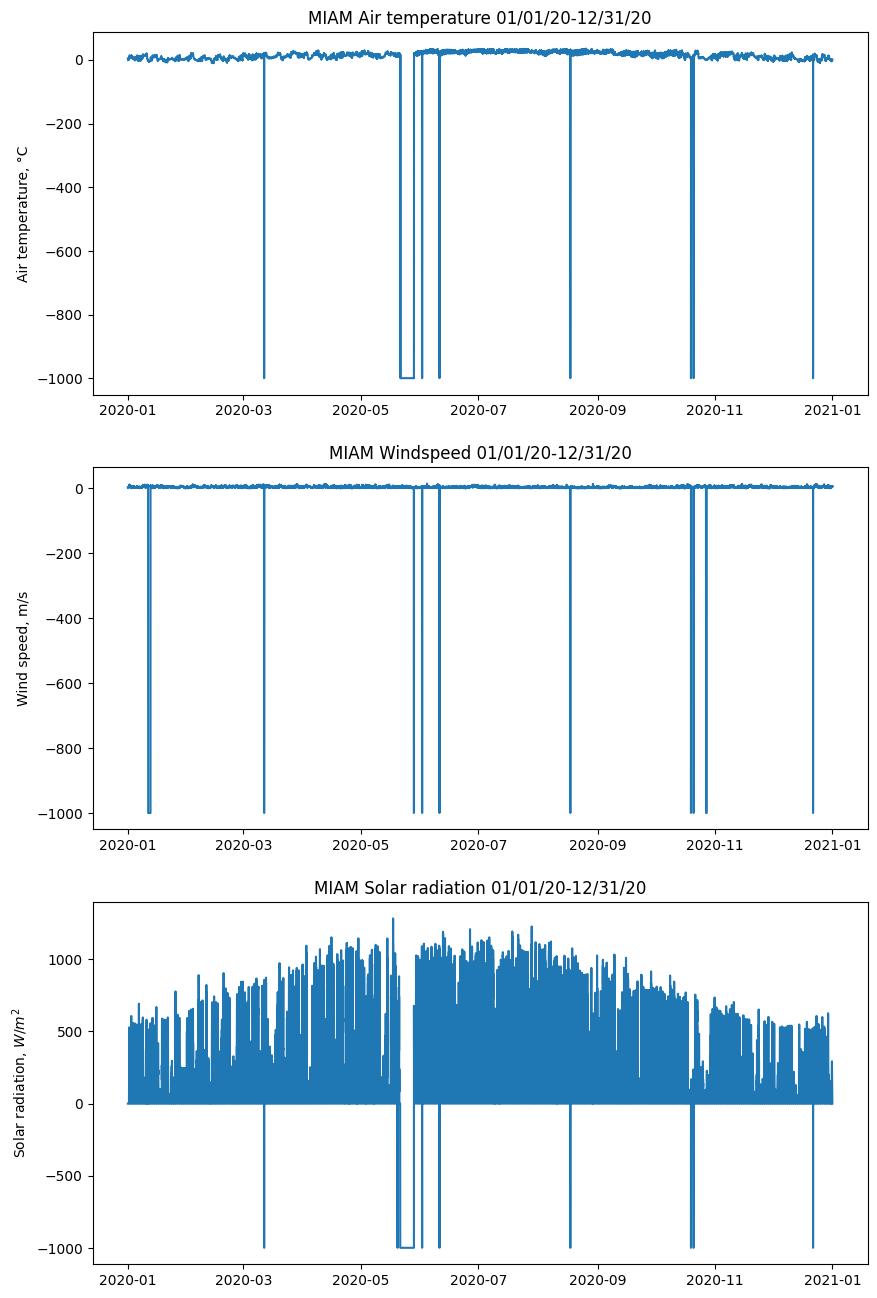

In [9]:
fig = pyplot.figure(figsize = (10,16))
ax = fig.add_subplot(111)
ax1 = pyplot.subplot(3,1,1)
ax2 = pyplot.subplot(3,1,2)
ax3 = pyplot.subplot(3,1,3)
ax1.plot(station_data.index,station_data['TAIR'])
ax2.plot(station_data.index,station_data['WSPD'])
ax3.plot(station_data.index,station_data['SRAD'])
ax1.set_ylabel('Air temperature, °C')
ax2.set_ylabel('Wind speed, m/s')
ax3.set_ylabel('Solar radiation, $W/m^2$')
ax1.set_title('{} Air temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax2.set_title('{} Windspeed {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax3.set_title('{} Solar radiation {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))

# MesonetTools Class
<br>
The MesonetTools class contains methods for handling missing data and saving downloaded data to different formats. The initialization function has one optional parameter:

- verbose: Equivalent to the verbose argument in the MesonetDownloader class, this is a boolean argument that determines whether or not verbose logging will be sent to stdout. False by default.

## Handling Missing Data
MesonetTools provides four methods that deal with missing data: one to describe the missing data and three to handle it.

1. summarize_missing(df,graph=False)
2. replace_errors(df,code=1,column=None)
3. interpolate_missing(df,codes=[],column=None)
4. fill_neighbor_data(df,downloader,codes=[],column=None)

Missing data is represented by the error codes -995 to -999. A description of each error code can be found by running help(MesonetTools.replace_errors) or at the following link: https://www.mesonet.org/index.php/site/about/mdf_mts_files.

In [10]:
#Description of each error code with missing data in the climate timeseries
help(MesonetTools.replace_errors)

Help on function replace_errors in module okmesopy.mesonettools:

replace_errors(self, df, code=1, column=None)
    Replace error codes in the dataset with NaN.
    
    Description of error codes:
        -999 - flagged bad by QA routines
        -998 - sensor not installed
        -997 - missing calibration coefficients
        -996 - station did not report
        -995 - data not reported on this time interval
        -994 - value is too wide to fit in column
    arguments:
        df (DataFrame or dict): the dataframe or dictionary of dataframes
            to be manipulated
        code (int): the specific error code to be replaced, the default 1
            replaces all error codes
        column (str): optional parameter that when specified changes only
            a single column
    
    returns:
        DataFrame or dict: the modified df object



# Summary of the missing climate data
The simmarize_missing(df, graph = False) function prints all the missinf data in the downloaded climate data that is stored as a dataframe. In the function the "df" argument must be a single dataframe, not a dictionary of dataframes. There is an optional graph argument which when set to "True" will be using the Missigno library to display the missing data in a graphical depicition.

Missing data summary for MIAM station:
-----------------------
To see a description of each error code run help(MesonetTools.replace_errors)
Note: the -995 error code is used when data is not collected on an interval. This code is generally normal and expected.
There are 644480 total missing data points and 29592 missing data data points excluding -995 codes
The following chart displays the number of each kind of error code found in each column of the DataFrame.

       -994    -995  -996  -997  -998   -999   TOTAL
RELH      0       0     0     0     0     63      63
TAIR      0       0    17     0     0   2070    2087
WSPD      0       0     0     0     0    535     535
WVEC      0       0     0     0     0    535     535
WDIR      0       0     0     0     0    535     535
WDSD      0       0     0     0     0    535     535
WSSD      0       0     0     0     0    535     535
WMAX      0       0     0     0     0    535     535
RAIN      0       8     0     0     0     63      71
PR

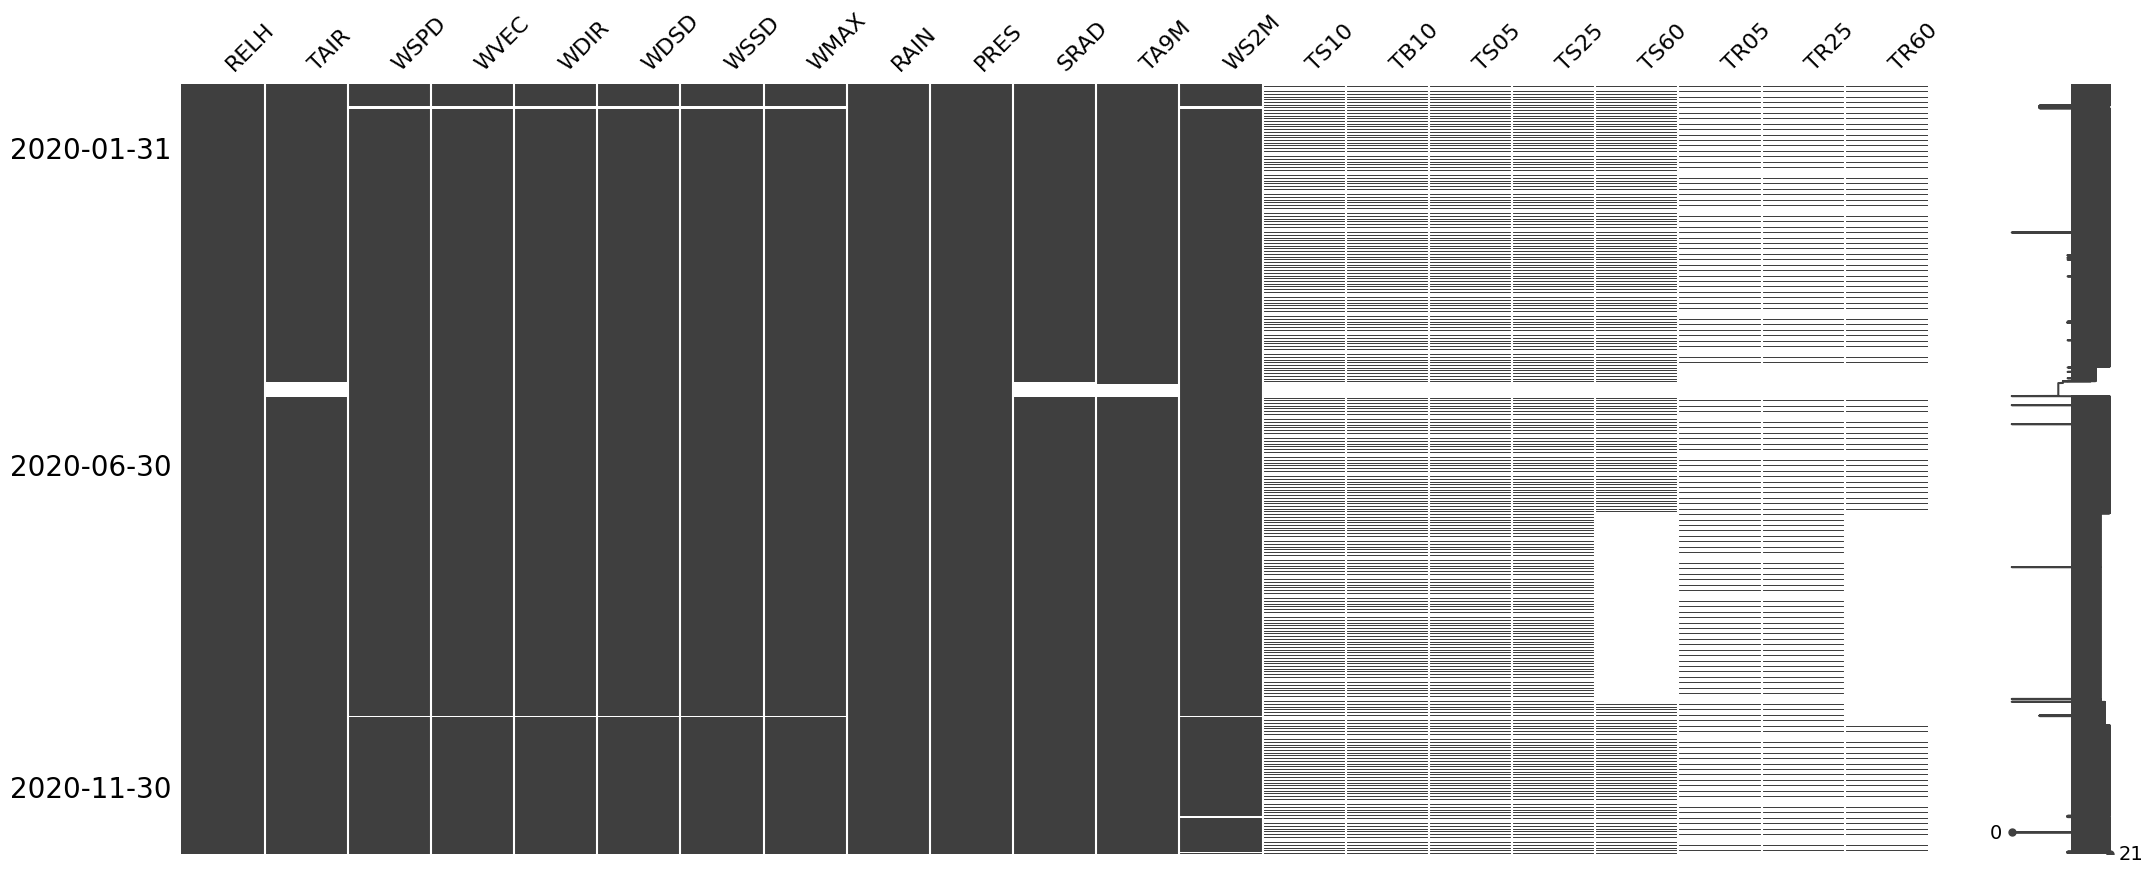

In [11]:
tools.summarize_missing(station_data,graph=True)

# Interpolating the missing climate data
As seen in the summary there are a few missing data points in the climate dataset. To get a smooth timeseries we are using linear interpolation to estimate the missing data. The interpolate_missing(df, codes = [], colum = None) function that uses simple linear interpolation to estimate the missing data values. The argument "df" needs to be a single dataframe and "codes" is an optional argument that expects a list of error codes shown in the summary that are replaced with interpolated data.

In [12]:
#interpolating the missing data in the entire dataframe
st_int_data = tools.interpolate_missing(station_data)

In [13]:
st_int_data.head()

,STID,RELH,TAIR,WSPD,WVEC,WDIR,WDSD,WSSD,WMAX,RAIN,...,TA9M,WS2M,TS10,TB10,TS05,TS25,TS60,TR05,TR25,TR60
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,MIAM,50.0,4.5,2.7,2.7,227.0,3.4,0.2,3.5,0.0,...,6.4,1.4,6.400000,5.500000,6.100000,7.200000,9.5,1.47,1.420000,1.38
2020-01-01 00:05:00,MIAM,50.0,4.3,2.7,2.7,227.0,4.0,0.2,3.4,0.0,...,6.3,1.4,6.366667,5.466667,6.066667,7.200000,9.5,1.47,1.421667,1.38
2020-01-01 00:10:00,MIAM,51.0,4.3,2.7,2.7,226.0,5.1,0.2,3.3,0.0,...,6.2,1.3,6.333333,5.433333,6.033333,7.200000,9.5,1.47,1.423333,1.38
2020-01-01 00:15:00,MIAM,51.0,4.1,2.5,2.5,226.0,5.4,0.2,3.4,0.0,...,6.0,1.2,6.300000,5.400000,6.000000,7.200000,9.5,1.47,1.425000,1.38
2020-01-01 00:20:00,MIAM,51.0,4.1,2.3,2.3,222.0,5.8,0.2,2.8,0.0,...,5.9,1.1,6.300000,5.333333,5.966667,7.166667,9.5,1.47,1.426667,1.38


<ipython-input-14-a3915d7e5767>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = pyplot.subplot(3,1,1)


Text(0.5, 1.0, 'MIAM Solar radiation 01/01/20-12/31/20')

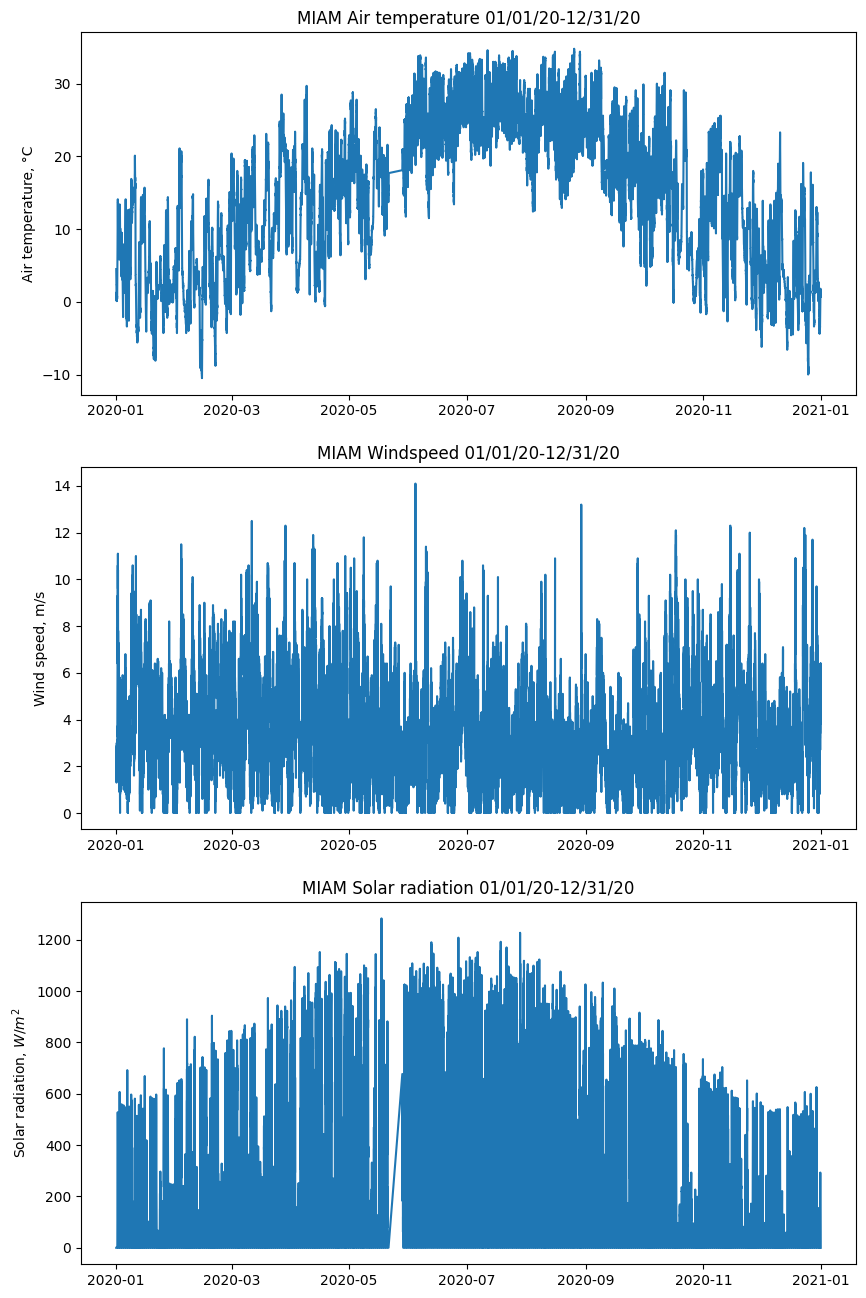

In [14]:
#plotting the new dataframe with interpolated values to visualize the climate timeseries
fig = pyplot.figure(figsize = (10,16))
ax = fig.add_subplot(111)
ax1 = pyplot.subplot(3,1,1)
ax2 = pyplot.subplot(3,1,2)
ax3 = pyplot.subplot(3,1,3)
ax1.plot(st_int_data.index,st_int_data['TAIR'])
ax2.plot(st_int_data.index,st_int_data['WSPD'])
ax3.plot(st_int_data.index,st_int_data['SRAD'])
ax1.set_ylabel('Air temperature, °C')
ax2.set_ylabel('Wind speed, m/s')
ax3.set_ylabel('Solar radiation, $W/m^2$')
ax1.set_title('{} Air temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax2.set_title('{} Windspeed {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax3.set_title('{} Solar radiation {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))

# Filling missing data with neighboring station
From  the summary and the visualization, it is clear that a bunch of climate data is missing for the MIAM station during late May of the year 2020. Therefore we cannot use the interpolate method to estimate the missing data. This tool has a function fill_neighbor_data(df, downloader, codes = [], column=None) replaces the missing data from the nearest reporting station. This function expects the MesonetDownloader object because the tool needs to access the climate data from the neighboring station to fill the missing data. Therefore we are replacing the missing climate data with the data from the neighboring station

In [15]:
#filling the missing climate data with the nearest reporting station
st_nei_data = tools.fill_neighbor_data(station_data,downloader)

<ipython-input-16-66e65b447a65>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = pyplot.subplot(3,1,1)


Text(0.5, 1.0, 'MIAM Solar radiation 01/01/20-12/31/20')

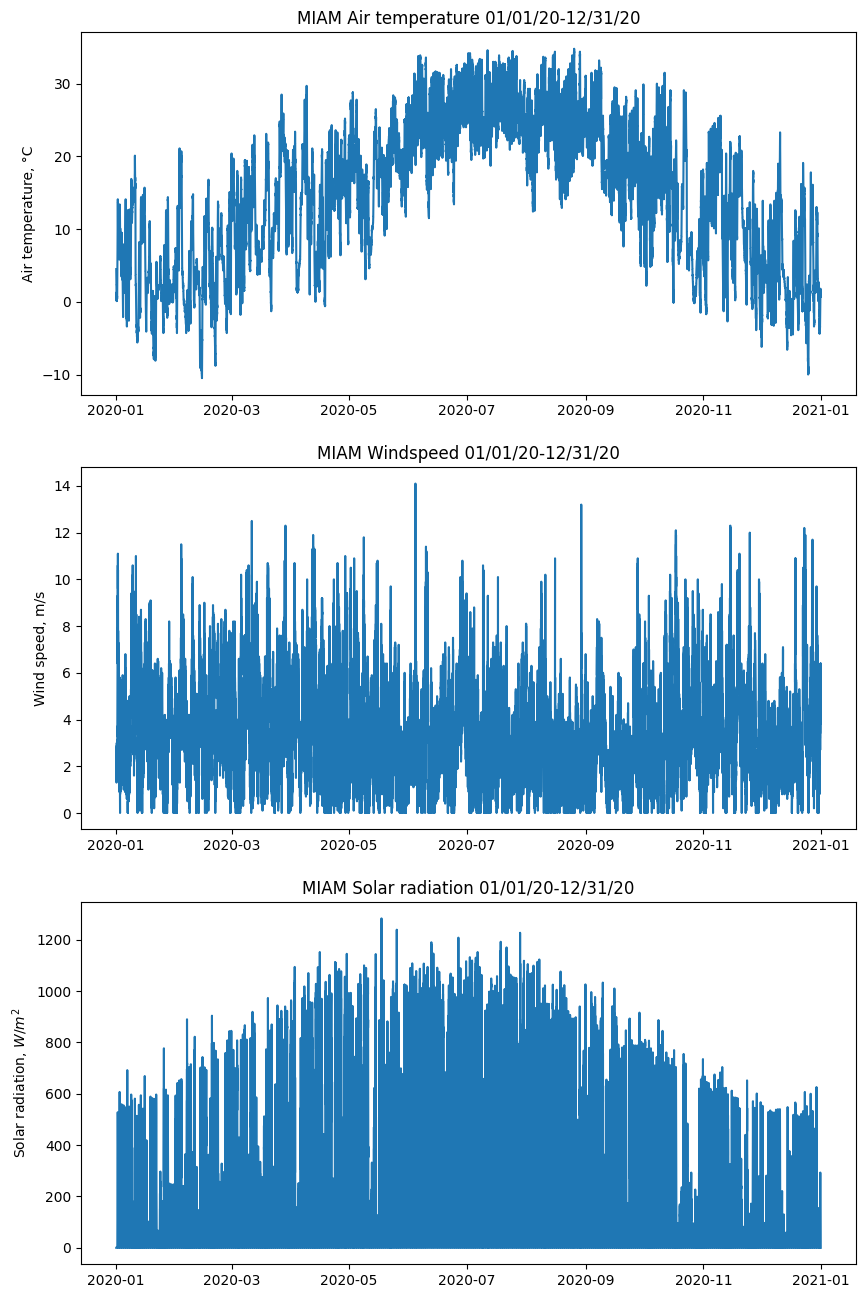

In [16]:
#plotting the new dataframe with filled missing data with nearest station visualize the climate timeseries
fig = pyplot.figure(figsize = (10,16))
ax = fig.add_subplot(111)
ax1 = pyplot.subplot(3,1,1)
ax2 = pyplot.subplot(3,1,2)
ax3 = pyplot.subplot(3,1,3)
ax1.plot(st_nei_data.index,st_nei_data['TAIR'])
ax2.plot(st_nei_data.index,st_nei_data['WSPD'])
ax3.plot(st_nei_data.index,st_nei_data['SRAD'])
ax1.set_ylabel('Air temperature, °C')
ax2.set_ylabel('Wind speed, m/s')
ax3.set_ylabel('Solar radiation, $W/m^2$')
ax1.set_title('{} Air temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax2.set_title('{} Windspeed {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax3.set_title('{} Solar radiation {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))

# Climate data parameters for ET estimation
The parameters needed for ET estimation using penman monteith equation include: Air temperature, Dewpoint temperature, Wind speed, Solar radiation. From the MDF/MTS files we get the required climate parameters with ID's, TAIR (Air temperature), WSPD (Wind speed), SRAD (Solar radiation). The dewpoint temperature is estimated that can be used later for ET estimations. There are several relationships that have been developed between temperature, relative humidity, and dewpoint temperature. However, in this example we are using the dewpoint temperature estimation based on Magnus-teetens formula as expained in detail here: https://journals.ametsoc.org/view/journals/bams/86/2/bams-86-2-225.xml. The equation developed by Magnus-teetens to estimate dewpoint temperature is as follows:

$T_s = (b \times \alpha(T,RH) / (a - \alpha(T,RH))$
<br>
Where $\alpha(T,RH) = ln(RH/100) + aT/(b+T)$;

<br>
$T_s$ is Dewpoint temperature (in Celsius),
<br>
$T$ is Air temperature (in Celsius),
<br>
$RH$ is Relative humidity of the air (in Percentage),
<br>
a,b are Magnus coefficients where a = 17.625 and b = 243.04,
<br>
This equation to estimate Dewpoint temperature is able to obtain accurate results with temperatures raingin from -45 $^o$C to 60 $^o$C

In [17]:
#Estimating the Dewpoint temperature using the cleaned climate data with smooth timeserie
a = 17.625
b = 243.03
alpha = np.log(st_nei_data["RELH"]/100) + (a*st_nei_data["TAIR"]/(b+st_nei_data["TAIR"]))
st_nei_data["TDEW"] = (b * alpha) / (a - alpha)

In [18]:
#printing the dataframe information
print(st_nei_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105408 entries, 2020-01-01 00:00:00 to 2020-12-31 23:55:00
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   STID    105408 non-null  object 
 1   RELH    105408 non-null  float64
 2   TAIR    105408 non-null  float64
 3   WSPD    105408 non-null  float64
 4   WVEC    105408 non-null  float64
 5   WDIR    105408 non-null  float64
 6   WDSD    105408 non-null  float64
 7   WSSD    105408 non-null  float64
 8   WMAX    105408 non-null  float64
 9   RAIN    105408 non-null  float64
 10  PRES    105408 non-null  float64
 11  SRAD    105408 non-null  float64
 12  TA9M    105408 non-null  float64
 13  WS2M    105408 non-null  float64
 14  TS10    105408 non-null  float64
 15  TB10    105408 non-null  float64
 16  TS05    105408 non-null  float64
 17  TS25    105408 non-null  float64
 18  TS60    105408 non-null  float64
 19  TR05    105408 non-null  float64
 20  TR25    105408

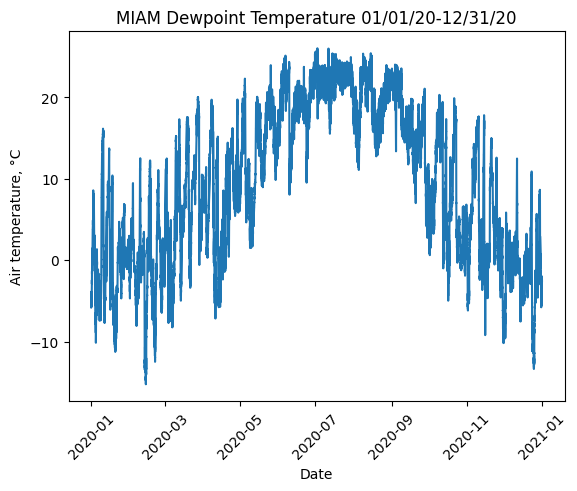

In [19]:
#visualizing the timeseries of the dewpoint temperature
pyplot.plot(st_nei_data.index,st_nei_data["TDEW"])
pyplot.title('{} Dewpoint Temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
pyplot.xlabel('Date')
pyplot.ylabel('Air temperature, °C')
ticks = pyplot.xticks(rotation = 45)

 Until this part of the example, we have acquired the climate dataset and from Oklahoma mesonet station using OKMesopy and estimated Dewpoint temperature. All the required climate parameters for ET estimation are visualized as timeseries with 5 minute time resolution for the year 2020. In the next part of this example, we are resampling the climate datasets from 5 minute time resolutions to hourly resolution to reduce the computation time.

# Resampling climate data to hourly
When it comes to time series, resampling is a critical technique that allows flexibility while defining the time resolution. There are two prerequisites for carrying out sampling. The two prerequisites are as follows:
1. The datetime column needs to be in "datetime" or "timestamp" format
2. The datetime column should be in the index of the dataframe. An alternative is to define the column to carry out resampling on a defined parameter

In [20]:
#Taking the necessary parameters for data resampling that are used later to estimate hourly evapotranspiration
dc_resampled = st_nei_data[[ "TAIR", "TDEW", "WSPD", "SRAD"]]
dc_resampled.head()

,TAIR,TDEW,WSPD,SRAD
DATETIME,,,,
2020-01-01 00:00:00,4.5,-5.033130,2.7,0.0
2020-01-01 00:05:00,4.3,-5.218028,2.7,0.0
2020-01-01 00:10:00,4.3,-4.956282,2.7,0.0
2020-01-01 00:15:00,4.1,-5.141598,2.5,0.0
2020-01-01 00:20:00,4.1,-5.141598,2.3,0.0


In [21]:
#Resampling 5 minute data to hourly data for ET estimation
dc_hourly = dc_resampled.resample('H').mean()
dc_hourly.head()

,TAIR,TDEW,WSPD,SRAD
DATETIME,,,,
2020-01-01 00:00:00,3.925000,-5.114654,2.358333,0.0
2020-01-01 01:00:00,3.033333,-5.503358,2.300000,0.0
2020-01-01 02:00:00,2.208333,-5.466213,1.600000,0.0
2020-01-01 03:00:00,0.808333,-4.655929,1.508333,0.0
2020-01-01 04:00:00,0.916667,-4.919688,1.891667,0.0


In [22]:
#Resetting the index and printing the head of the resampled dataframe
dc_hourly = dc_hourly.reset_index()
dc_hourly.head()

,DATETIME,TAIR,TDEW,WSPD,SRAD
0,2020-01-01 00:00:00,3.925000,-5.114654,2.358333,0.0
1,2020-01-01 01:00:00,3.033333,-5.503358,2.300000,0.0
2,2020-01-01 02:00:00,2.208333,-5.466213,1.600000,0.0
3,2020-01-01 03:00:00,0.808333,-4.655929,1.508333,0.0
4,2020-01-01 04:00:00,0.916667,-4.919688,1.891667,0.0


In [23]:
# Download the pan evaporation from the github
# URL where the pan evaporation data are
git = 'https://github.com/abhiramp1/okmesopy/blob/main/examples/ET-files/Mesonet_ET_Daily_MIAM.txt?raw=true'

# assigning the path to a variable
urllib.request.urlretrieve(git, "Mesonet_ET_Daily_MIAM.txt")

('Mesonet_ET_Daily_MIAM.txt', <http.client.HTTPMessage at 0x7f164b830460>)

# Data visualization of pan evaporation data
Pan evaporation is a measurement that integrates the effects of climate parameters including temperature, humidity, rainfall, solar radiation, and wind. we are going to be using the pan evaporation data as the in-situ data to assess the estimation of the evapotranspiration using the penman monteith

In [24]:
#reading the pan evaporation file with daily resolution for Miami station
pfile = pd.read_csv("Mesonet_ET_Daily_MIAM.txt", delim_whitespace=True)

In [25]:
#printing the information of the pan evaporation dataframe
pfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     7305 non-null   int64  
 1   MM       7305 non-null   int64  
 2   DD       7305 non-null   int64  
 3   ETOS     7305 non-null   float64
 4   ETRS     7305 non-null   float64
 5   ETCOOL   7305 non-null   float64
 6   ETWARM   7305 non-null   float64
 7   PANEVAP  7305 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 456.7 KB


In [26]:
#printing the head of the pan evaporation data
pfile.head()

,YEAR,MM,DD,ETOS,ETRS,ETCOOL,ETWARM,PANEVAP
0,2001,1,1,0.01,0.01,0.01,0.01,0.01
1,2001,1,2,0.01,0.02,0.01,0.01,0.02
2,2001,1,3,0.02,0.02,0.02,0.01,0.02
3,2001,1,4,0.03,0.03,0.02,0.02,0.03
4,2001,1,5,0.03,0.04,0.03,0.02,0.03


# Pan evaporation data preprocessing for data visualization
From the printed pan evaporation dataframe information, it is clear that the date is not in datetime format. Therefore we are creating a new column with the datetime so that we can plot and observe the timeseries. The errors of the missing data are same as mentioned with the mesonet climate data

In [27]:
#reformatting the datetime column using the year, month, and day columns of the panevaporation file
cols=["YEAR","MM","DD"]
pfile['DATETIME'] = pfile[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
pfile.tail()

,YEAR,MM,DD,ETOS,ETRS,ETCOOL,ETWARM,PANEVAP,DATETIME
7300,2020,12,27,0.10,0.17,0.10,0.06,0.15,2020-12-27
7301,2020,12,28,0.03,0.04,0.02,0.02,0.03,2020-12-28
7302,2020,12,29,0.06,0.10,0.06,0.04,0.08,2020-12-29
7303,2020,12,30,0.03,0.04,0.03,0.02,0.04,2020-12-30
7304,2020,12,31,0.02,0.03,0.02,0.01,0.03,2020-12-31


In [28]:
#using the describe function of pandas to see the descriptive statistics of the dataframe and check the missing data points
pfile.describe()

,YEAR,MM,DD,ETOS,ETRS,ETCOOL,ETWARM,PANEVAP
count,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000
mean,2010.501027,6.522930,15.729637,-0.285680,-0.250215,-0.294465,-0.332975,-0.250201
std,5.766735,3.448939,8.800694,20.244804,20.245593,20.244608,20.243763,20.245621
min,2001.000000,1.000000,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,2006.000000,4.000000,8.000000,0.060000,0.080000,0.060000,0.040000,0.080000
50%,2011.000000,7.000000,16.000000,0.120000,0.150000,0.110000,0.070000,0.150000
75%,2016.000000,10.000000,23.000000,0.180000,0.230000,0.170000,0.110000,0.230000
max,2020.000000,12.000000,31.000000,0.380000,0.540000,0.360000,0.240000,0.560000


Seems like we have found a bunch of missing data points in the pan evaporation file. Also we observed that the errors of the missing data points has a error code of "-999". Therefore we are counting the total number of missing data with the error codes using a for loop

In [29]:
#Counting and printing to see how many values of panevaporation have missing data errors in the pan evaporation data
count  = 0
for i in pfile["PANEVAP"]:
    if i == -999:
        count = count + 1
print(count)

3


In [30]:
#Negative values in the pan evaportion data do not make sense and therefore replacing the error values with null values
pfile["PANEVAP"] = pfile["PANEVAP"].replace( -999, np.nan)

# Evaporation data units
The pan evaporation data available are in the units of inches per day. Once we estimate ET using penman monteith we get the estimated evapotranspiration in millimeters per time. Therefore we are converting the pan evaporation data into millimeters per time to maintain consistency in units

In [31]:
#The pan evaporation data available is in inches per day and converting the observed data into mm per day
pfile["PAN"] = pfile["PANEVAP"]*25.4

In [32]:
pfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      7305 non-null   int64  
 1   MM        7305 non-null   int64  
 2   DD        7305 non-null   int64  
 3   ETOS      7305 non-null   float64
 4   ETRS      7305 non-null   float64
 5   ETCOOL    7305 non-null   float64
 6   ETWARM    7305 non-null   float64
 7   PANEVAP   7302 non-null   float64
 8   DATETIME  7305 non-null   object 
 9   PAN       7302 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 570.8+ KB


# Estimating hourly ET using ETcalculator
ETCalculator is a class from PyHSPF that is used in this example to compute hourly ET from the climate timeseries downloaded using OKMesopy. The ETCalculator uses the Penman-Monteith Equation to estimate ET.

In [33]:
#initiating the ETCalculator
calculator = etcalculator.ETCalculator()

In [34]:
#Assigning the series data of the hourly climate data to lists
hourlytemps = dc_hourly["TAIR"].to_list()
hdewt = dc_hourly["TDEW"].to_list()
hwind = dc_hourly["WSPD"].to_list()
solar = dc_hourly["SRAD"].to_list()
print(len(hourlytemps),len(hdewt), len(hwind), len(solar))

8784 8784 8784 8784


Some of the parameters in the Penman-Monteith Equation depends on the geographic location and elevation. Therefore information such as latitude, longitude, and elevation of the Miami station is provided to the ETCalculator.

In [35]:
#Providing the geographic information and elevation to the ETcalculator
elevation = 247
lon, lat, elev = downloader.get_station_coord(stid)[1], downloader.get_station_coord(stid)[0], elevation
calculator.add_location(lon, lat, elev)

In [36]:
#Providing the start and end datetime such that they can be provided to the ETcalculator
start = datetime(2020, 1, 1)
end   = datetime(2020, 12, 31)

In [37]:
#The hourly climate timeseries are added to the ETcalculator
calculator.add_timeseries('temperature', 'hourly', start, hourlytemps)
calculator.add_timeseries('dewpoint',    'hourly', start, hdewt)
calculator.add_timeseries('wind',        'hourly', start, hwind)
calculator.add_timeseries('solar', 'hourly', start, solar)

In [38]:
#Estimating the reference evapotranspiration (RET) time series with the penman_hourly function of the ETcalculator
calculator.penman_hourly(start, end)

calculating hourly reference evapotranspiration...

2.8791840000000004 0.0092466936890831
finished calculating reference evapotranspiration



In [39]:
#creating the pointers to the time series in the calculator
start,evap = calculator.hourly['RET']

In [40]:
#assigning the evaporation numpy array to a dataframe for resampling
evap_hourly = pd.concat([dc_hourly["DATETIME"], pd.Series(evap)], axis=1)

In [41]:
#assigning column headers to the evaporation dataframe
evap_hourly.columns = ['DATETIME', 'evaporation']

In [42]:
#aggregating the ET data to daily for visualization purposes using datetime column as index
evap_daily = evap_hourly.set_index("DATETIME").resample('D').sum()

In [43]:
#resetting the index of the dataframe such that the DATETIME column is not an index anymore
evap_daily = evap_daily.reset_index()

In [44]:
evap_daily.tail()

,DATETIME,evaporation
361,2020-12-27,2.664318
362,2020-12-28,0.689907
363,2020-12-29,0.873502
364,2020-12-30,0.370343
365,2020-12-31,0.000000


In [45]:
dc_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105408 entries, 2020-01-01 00:00:00 to 2020-12-31 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TAIR    105408 non-null  float64
 1   TDEW    105408 non-null  float64
 2   WSPD    105408 non-null  float64
 3   SRAD    105408 non-null  float64
dtypes: float64(4)
memory usage: 8.1 MB


In [46]:
#dc_resampled = dc_resampled.reset_index()

In [47]:
#resample the climate data to daily because the pan evaporation data available is daily.
#The resampled daily data is easy to visualize compared to 5 minutes and hourly resolution
dc_daily = dc_resampled.resample('D').mean()
dc_daily.head()

,TAIR,TDEW,WSPD,SRAD
DATETIME,,,,
2020-01-01,4.963542,-3.503209,4.527083,127.364583
2020-01-02,9.053819,4.667230,3.752083,54.190972
2020-01-03,6.886458,4.006702,2.980208,71.864583
2020-01-04,3.436111,-5.737208,3.067014,137.263889
2020-01-05,5.900694,-4.187703,3.465972,135.350694


In [48]:
#The year 2020 is a leap year therefore we are printing the datetime of the daily estimtated evaporation dataframe
#and pan evaporation dataframe has the same length
len(evap_daily['DATETIME']),len(pfile['DATETIME'][6939:])

(366, 366)

In [49]:
evap_daily.head()

,DATETIME,evaporation
0,2020-01-01,1.612624
1,2020-01-02,0.919546
2,2020-01-03,0.608710
3,2020-01-04,1.466449
4,2020-01-05,1.784453


<ipython-input-50-5e6e25c46942>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = pyplot.subplot(4,1,1)


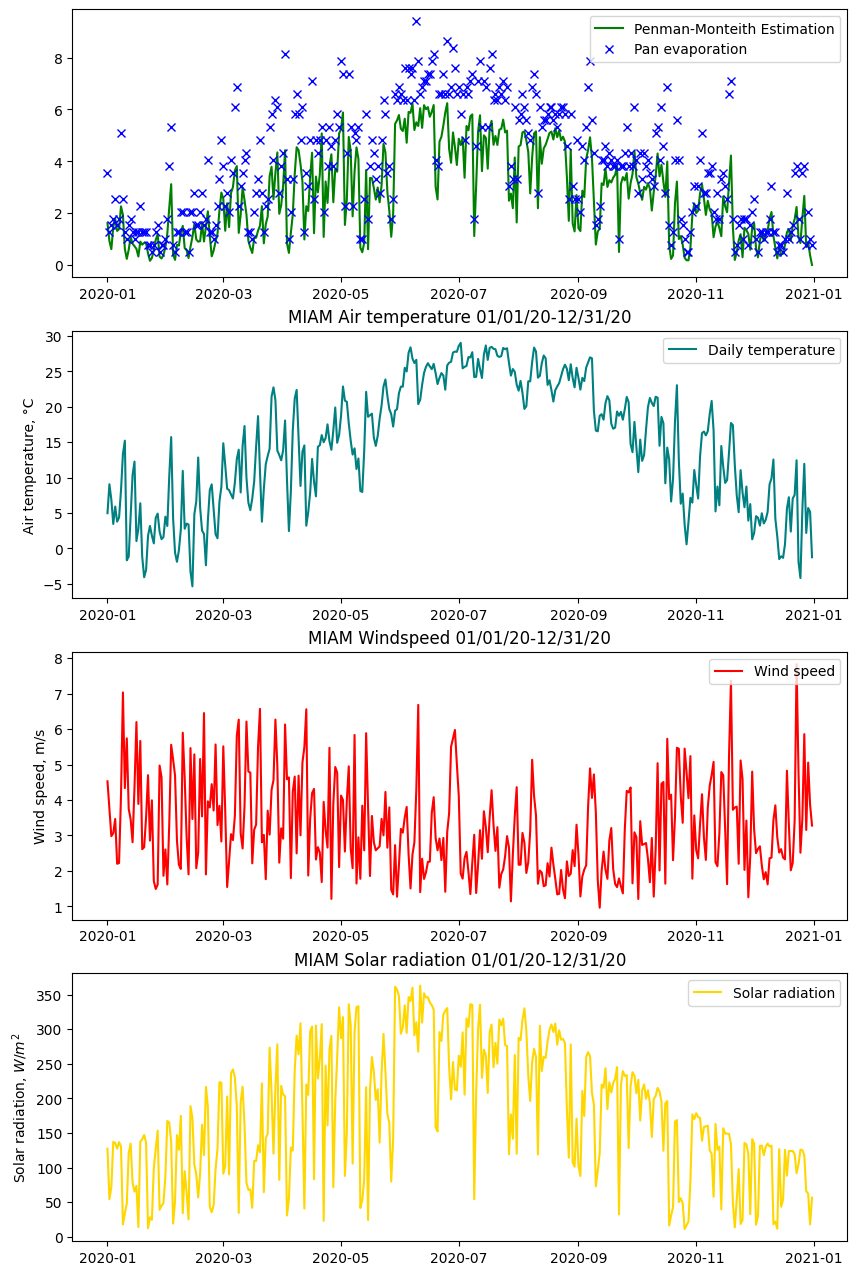

In [50]:
#plotting the ET and the other climate parameters used in the estimation of reference ET
fig = pyplot.figure(figsize = (10,16))
ax = fig.add_subplot(111)
ax1 = pyplot.subplot(4,1,1)
ax2 = pyplot.subplot(4,1,2)
ax3 = pyplot.subplot(4,1,3)
ax4 = pyplot.subplot(4,1,4)
ax1.plot(evap_daily['DATETIME'],evap_daily['evaporation'], color = 'green', label = 'Penman-Monteith Estimation')
ax1.plot(evap_daily['DATETIME'], pfile['PAN'][6939:], 'x', color = 'blue', label = 'Pan evaporation')
ax2.plot(dc_daily.index,dc_daily['TAIR'], color = 'teal', label = 'Daily temperature')
ax3.plot(dc_daily.index,dc_daily['WSPD'], color = 'red', label = 'Wind speed')
ax4.plot(dc_daily.index,dc_daily['SRAD'], color = 'gold', label = 'Solar radiation')
ax2.set_ylabel('Air temperature, °C')
ax3.set_ylabel('Wind speed, m/s')
ax4.set_ylabel('Solar radiation, $W/m^2$')
ax2.set_title('{} Air temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax3.set_title('{} Windspeed {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax4.set_title('{} Solar radiation {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

# Regression plot and statistics
The stats.linregress() function calculates a linear least-square regression for two sets of measurements. In this example we have plotted between observed pan evaporation and estimated ET. A linear fit is passed through the scatter plot such that the R2 value is 0.91.

LinregressResult(slope=0.748295994786583, intercept=-0.16881021493298842, rvalue=0.9543630016936661, pvalue=3.980345019264488e-193, stderr=0.012273552551187781, intercept_stderr=0.05419395425585709)


Text(0, 0.5, 'Estimated penman monteith evaporation')

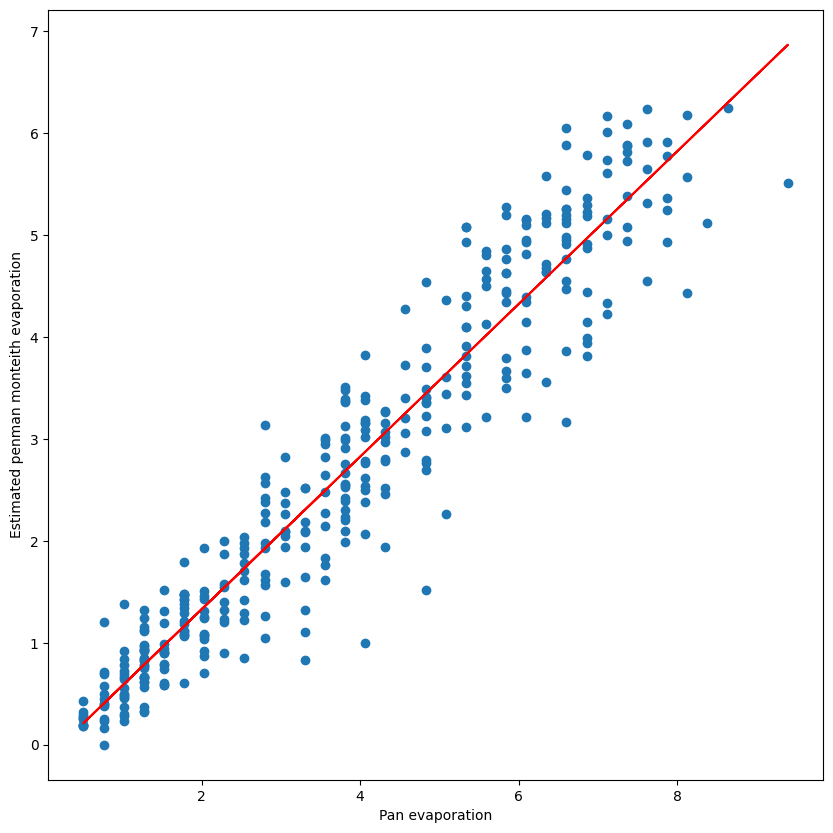

In [51]:
res = stats.linregress(pfile['PAN'][6939:], evap_daily['evaporation'])
print(res)
fig = pyplot.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.scatter(pfile['PAN'][6939:],evap_daily['evaporation'])
ax.plot(np.array(pfile['PAN'][6939:]), res.intercept + res.slope*np.array(pfile['PAN'][6939:]), 'r', label='fitted line')
ax.set_xlabel("Pan evaporation")
ax.set_ylabel("Estimated penman monteith evaporation")

In [52]:
#The coefficient of determintation for RET estimation
slope, intercept, r_value, p_value, std_err = stats.linregress(pfile['PAN'][6939:],evap_daily['evaporation'])
print("r-squared:", r_value**2)

r-squared: 0.9108087390017444
